In [11]:
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"]="0" 

import tensorflow as tf
from tensorflow import keras

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

Default GPU Device: /device:GPU:0


In [48]:

class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=15, image_size=512, shuffle = True):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path, id_name)
        mask_path = os.path.join(self.path,'labels', id_name)
        #all_masks = os.listdir(mask_path)
        ## Reading Image
        image = cv2.imread(image_path, 1)
        #image = cv2.resize(image, (self.image_size, self.image_size))
        
        #mask = np.zeros((self.image_size, self.image_size, 1))
        
        ## Reading Masks
        mask_path = mask_path
        _mask_image = cv2.imread(mask_path, -1)
        #_mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size)) #512x512
        _mask_image = np.expand_dims(_mask_image, axis=-1)
        #mask = np.maximum(mask, _mask_image)
        
        ## Normalizaing 
        image = image/255.0
        _mask_image = _mask_image/255.0
        
        return image, _mask_image
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.ids))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))


In [49]:
image_size = 512
train_path = r"/home/handenur/Desktop/dataset/frames/"
epochs = 100
batch_size = 2

## Training Ids
train_ids = next(os.walk(train_path))[2]
print(train_ids)
## Validation Data Size
val_data_size = 500

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]

['ns100a1199_resized_512.png', 'ns100a1201_resized_512.png', 'ns100a1203_resized_512.png', 'ns100a1205_resized_512.png', 'ns100a1207_resized_512.png', 'ns100a1209_resized_512.png', 'ns100a1211_resized_512.png', 'ns100a1213_resized_512.png', 'ns100a1215_resized_512.png', 'ns100a1217_resized_512.png', 'ns100a1219_resized_512.png', 'ns100a1221_resized_512.png', 'ns100a1223_resized_512.png', 'ns100a1225_resized_512.png', 'ns100a1227_resized_512.png', 'ns100a1229_resized_512.png', 'ns100a1231_resized_512.png', 'ns100a1233_resized_512.png', 'ns100a1235_resized_512.png', 'ns100a1237_resized_512.png', 'ns100a1239_resized_512.png', 'ns100a1241_resized_512.png', 'ns100a1243_resized_512.png', 'ns100a1245_resized_512.png', 'ns100a1247_resized_512.png', 'ns100a1249_resized_512.png', 'ns100a1251_resized_512.png', 'ns100a1253_resized_512.png', 'ns100a1255_resized_512.png', 'ns100a1257_resized_512.png', 'ns100a1259_resized_512.png', 'ns100a1345_resized_512.png', 'ns100a1347_resized_512.png', 'ns100a13

In [50]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)
print(y)

(2, 512, 512, 3) (2, 512, 512, 1)
[[[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]]


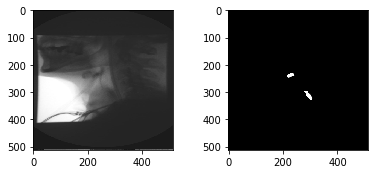

In [51]:
r = random.randint(0, len(x)-1)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

In [52]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [53]:
def UNet():
    f = [16, 32, 64, 128, 256, 512]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #256--->128
    c2, p2 = down_block(p1, f[1]) #128--->64
    c3, p3 = down_block(p2, f[2]) #64--->32
    c4, p4 = down_block(p3, f[3]) #32--->16
    c5, p5 = down_block(p4, f[4]) #16--->8
    
    bn = bottleneck(p5, f[5])
    
    u1 = up_block(bn, c5, f[4]) #8--->16
    u2 = up_block(u1, c4, f[3]) #16--->32
    u3 = up_block(u2, c3, f[2]) #32--->64
    u4 = up_block(u3, c2, f[1]) #64--->128
    u5 = up_block(u4, c1, f[0]) #128--->256
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u5)
    model = keras.models.Model(inputs, outputs)
    return model

In [54]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_69 (Conv2D)              (None, 512, 512, 16) 448         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_70 (Conv2D)              (None, 512, 512, 16) 2320        conv2d_69[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_15 (MaxPooling2D) (None, 256, 256, 16) 0           conv2d_70[0][0]                  
____________________________________________________________________________________________

In [55]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=epochs)

Epoch 1/100
1203/1203 [==============================] - 88s 74ms/step - loss: 0.0651 - acc: 0.9896 - val_loss: 0.0266 - val_acc: 0.9949
Epoch 2/100
1203/1203 [==============================] - 81s 67ms/step - loss: 0.0473 - acc: 0.9895 - val_loss: 0.0252 - val_acc: 0.9949
Epoch 3/100
1203/1203 [==============================] - 80s 67ms/step - loss: 0.0393 - acc: 0.9895 - val_loss: 0.0212 - val_acc: 0.9949
Epoch 4/100
1203/1203 [==============================] - 80s 67ms/step - loss: 0.0335 - acc: 0.9900 - val_loss: 0.0244 - val_acc: 0.9951
Epoch 5/100
1203/1203 [==============================] - 81s 67ms/step - loss: 0.0310 - acc: 0.9903 - val_loss: 0.0168 - val_acc: 0.9951
Epoch 6/100
1203/1203 [==============================] - 81s 67ms/step - loss: 0.0295 - acc: 0.9905 - val_loss: 0.0161 - val_acc: 0.9954
Epoch 7/100
1203/1203 [==============================] - 80s 67ms/step - loss: 0.0274 - acc: 0.9910 - val_loss: 0.0155 - val_acc: 0.9952
Epoch 8/100
1203/1203 [==================

In [81]:
## Save the Weights
#model.save_weights("UNetW.h5")

## Dataset for prediction
x, y = valid_gen.__getitem__(0)
print(x)
print (x.shape, y.shape)
result = model.predict(x)

result = result > 0.5

[]
(0,) (0,)


ValueError: Error when checking input: expected input_4 to have 4 dimensions, but got array with shape (0, 1)

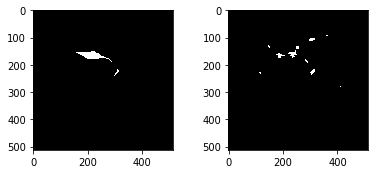

In [70]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

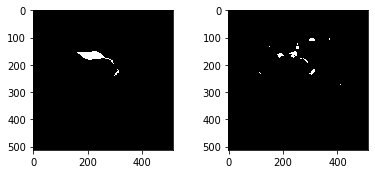

In [71]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[1]*255, (image_size, image_size)), cmap="gray")